In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import warnings
import warnings
import joblib
import json
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, train_test_split
import optuna

### Load data

In [2]:
data_train = pd.read_csv('../data/salary.train.processed.csv').set_index('id')
data_test = pd.read_csv('../data/salary.test.processed.csv').set_index('id')

- Compute correlation with target

In [3]:
X = data_train.drop(columns=['label'])
y = data_train['label']

In [4]:
corr_with_label = X.corrwith(y).abs().sort_values(ascending=False)

print("Top correlated features with label:")
print(corr_with_label.head(5))

Top correlated features with label:
marital-status_married-civ-spouse    0.509334
relationship_husband                 0.450938
marital-status_never-married         0.385850
education-num                        0.373260
capitalgain                          0.310260
dtype: float64


In [5]:
threshold = 0.1
selected_features = corr_with_label[corr_with_label >= threshold].index.tolist()

In [6]:
X_selected = X[selected_features]
print(f"Selected {len(selected_features)} features based on correlation >= {threshold}")

Selected 24 features based on correlation >= 0.1


In [7]:
corr_matrix = X_selected.corr().abs()

# Create upper triangle mask
upper = corr_matrix.where(~np.tril(np.ones(corr_matrix.shape)).astype(bool))

# Drop features with high inter-correlation
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

X_final = X_selected.drop(columns=to_drop)
print(to_drop)
print(f"Dropped {len(to_drop)} redundant features.")

['sex_female']
Dropped 1 redundant features.


- Heatmap

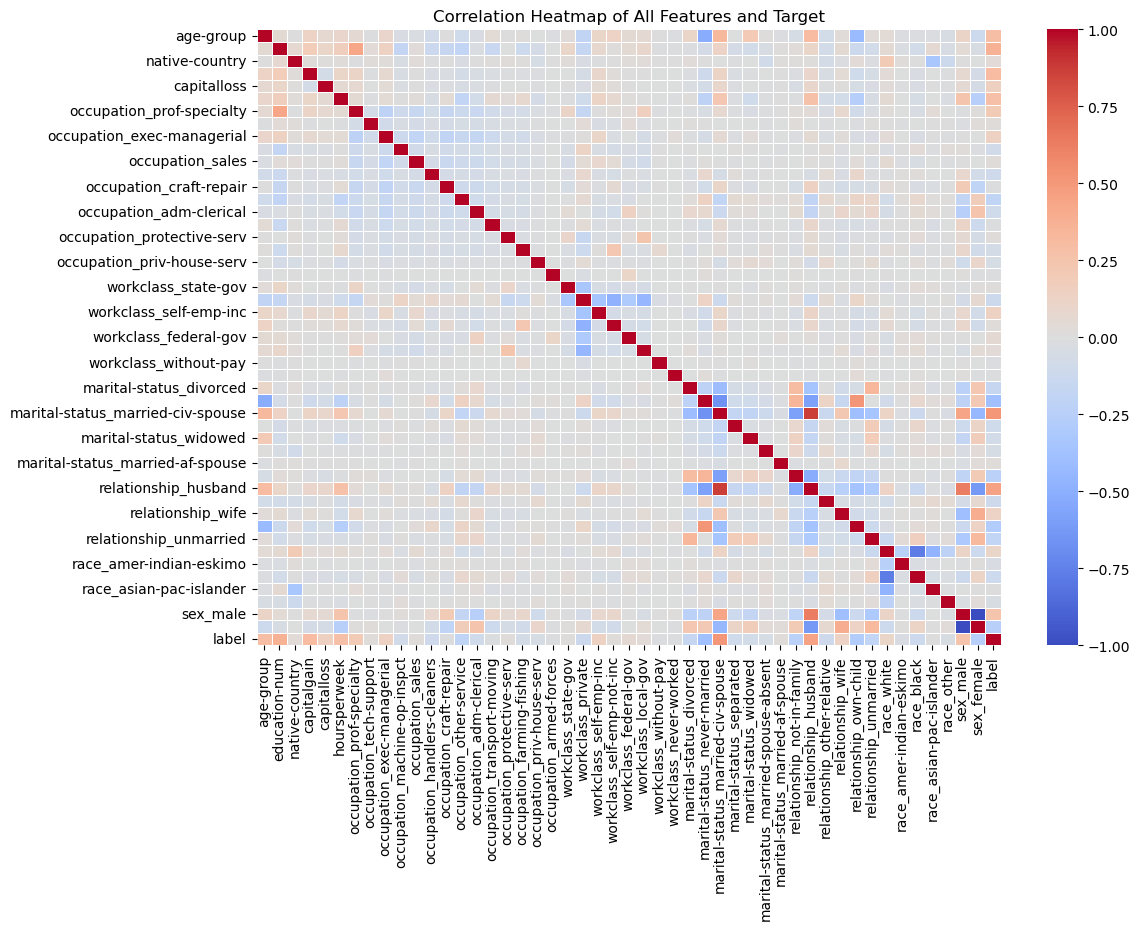

In [8]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt

# คำนวณ correlation matrix (เฉพาะ numeric features)
corr_matrix = data_train.corr(numeric_only=True)

# สร้าง heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    corr_matrix,
    annot=False,  # ไม่แสดงตัวเลขบน heatmap
    cmap='coolwarm',
    center=0,
    linewidths=0.5,  # ความหนาของเส้นแบ่ง
    linecolor='white'  # สีของเส้นแบ่ง
)
plt.title("Correlation Heatmap of All Features and Target")
plt.show()

In [9]:
print(f'select {len(selected_features)} features')

select 24 features


---

### Train base model & re-tune

set data

In [10]:
data_train = pd.read_csv('../data/salary.train.processed.csv').set_index('id')
data_test = pd.read_csv('../data/salary.test.processed.csv').set_index('id')
data_train = data_train[X_final.columns.tolist() + ['label']]
data_test = data_test[X_final.columns.tolist() + ['label']]

In [11]:
data_train

,marital-status_married-civ-spouse,relationship_husband,marital-status_never-married,education-num,capitalgain,age-group,relationship_own-child,hoursperweek,sex_male,relationship_not-in-family,...,capitalloss,occupation_exec-managerial,workclass_self-emp-inc,relationship_wife,workclass_private,race_black,race_white,relationship_other-relative,occupation_handlers-cleaners,label
id,,,,,,,,,,,,,,,,,,,,,
26890,0.0,0.0,0.0,16.0,0.0,3.0,1.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
933,0.0,0.0,0.0,14.0,4.0,3.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
25596,0.0,0.0,1.0,10.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12949,0.0,0.0,0.0,13.0,0.0,2.0,0.0,3.0,1.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
6681,1.0,1.0,0.0,9.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8695,0.0,0.0,1.0,10.0,0.0,0.0,0.0,2.0,1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2192,1.0,1.0,0.0,10.0,2.0,2.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8250,0.0,0.0,1.0,9.0,0.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


In [12]:
X_full = data_train.drop(columns=['label'])
y_full = data_train['label']

In [13]:
rf_class_weight = 'balanced' 
def objective(trial):    
    param_rf = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 14),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_float('max_features', 0.1, 1.0) 
    }
    

    model_rf = RandomForestClassifier(
        **param_rf,
        class_weight=rf_class_weight, 
        random_state=42,
        n_jobs=-1
    )
    score = cross_val_score(
        model_rf, 
        X_full, 
        y_full, 
        cv=10,                 
        scoring='f1_weighted',
        n_jobs=-1
    )
    
    f1_avg = np.mean(score)
    return f1_avg

print("\nFinding parameters with Optuna...")


pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='maximize', pruner=pruner)


study.optimize(
    objective, 
    n_trials=50,  
    show_progress_bar=True 
)


best_rf_params = study.best_params 
print("\n--- Optuna Finished! ---")


print("Best Parameters:")
print(study.best_params)

print(f"\nBest F1-Weighted (From CV): {study.best_value:.6f}")


[I 2025-11-07 14:53:32,556] A new study created in memory with name: no-name-5fc9538e-ce8e-4936-8416-af5209b5275a



Finding parameters with Optuna...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-07 14:53:58,774] Trial 0 finished with value: 0.7592471295822774 and parameters: {'n_estimators': 1000, 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 7, 'criterion': 'entropy', 'max_features': 0.42568450184985074}. Best is trial 0 with value: 0.7592471295822774.
[I 2025-11-07 14:54:08,787] Trial 1 finished with value: 0.8091007196850523 and parameters: {'n_estimators': 400, 'max_depth': 7, 'min_samples_leaf': 7, 'min_samples_split': 13, 'criterion': 'gini', 'max_features': 0.629204108504554}. Best is trial 1 with value: 0.8091007196850523.
[I 2025-11-07 14:54:23,369] Trial 2 finished with value: 0.8103411752958296 and parameters: {'n_estimators': 400, 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 2, 'criterion': 'gini', 'max_features': 0.9181405315591424}. Best is trial 2 with value: 0.8103411752958296.
[I 2025-11-07 14:54:53,350] Trial 3 finished with value: 0.8094547207056312 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'min_samples_le

- training with best params

In [14]:
X_train = data_train.drop(columns=['label'])
y_train = data_train['label']
X_test = data_test.drop(columns=['label'])
y_test = data_test['label']

model_base = RandomForestClassifier(
    **best_rf_params,
    random_state=42,
    n_jobs=-1)
model_base.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=13,
                       max_features=0.3051575239401323, min_samples_leaf=6,
                       min_samples_split=11, n_estimators=350, n_jobs=-1,
                       random_state=42)

- Prediction

In [15]:
data_test_base = data_test
data_test_base['prediction'] = model_base.predict(X_test)
data_test_base

,marital-status_married-civ-spouse,relationship_husband,marital-status_never-married,education-num,capitalgain,age-group,relationship_own-child,hoursperweek,sex_male,relationship_not-in-family,...,occupation_exec-managerial,workclass_self-emp-inc,relationship_wife,workclass_private,race_black,race_white,relationship_other-relative,occupation_handlers-cleaners,label,prediction
id,,,,,,,,,,,,,,,,,,,,,
12849,0.0,0.0,1.0,13.0,2.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1460,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13594,0.0,0.0,0.0,9.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
14400,0.0,0.0,0.0,9.0,0.0,3.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14333,1.0,1.0,0.0,9.0,0.0,2.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21121,1.0,1.0,0.0,9.0,0.0,3.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
12348,0.0,0.0,0.0,13.0,4.0,2.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
22298,1.0,1.0,0.0,13.0,0.0,3.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


- evaluate result

In [16]:
sklearn.metrics.confusion_matrix(
    y_true=data_test_base['label'],
    y_pred=data_test_base['prediction'],
)

array([[2001,  415],
       [ 309, 1455]], dtype=int64)

In [17]:
report_scores = sklearn.metrics.classification_report(
    y_true=data_test['label'],
    y_pred=data_test['prediction'],
    digits = 6,
    output_dict = True
)
df_score = pandas.DataFrame(report_scores).transpose()
df_score

,precision,recall,f1-score,support
0.0,0.866234,0.828228,0.846805,2416.000000
1.0,0.778075,0.824830,0.800771,1764.000000
accuracy,0.826794,0.826794,0.826794,0.826794
macro avg,0.822154,0.826529,0.823788,4180.000000
weighted avg,0.829030,0.826794,0.827378,4180.000000


- Save model and result

In [18]:
data_test_base.to_csv('./results/predictions.rf.base-feture-selection.csv')
joblib.dump(
    value = model_base,
    filename = './model/rf_model.base-feture-selection.joblib'
)
with open('./results/scores.rf.base-feture-selection.json','w')as f:
    json.dump(
        obj=report_scores,
        fp=f,
        indent = 4
    )

---

### Train with classweight + Feature selection

- load data

In [19]:
data_train = pd.read_csv('../data/salary.train.processed.csv').set_index('id')
data_test = pd.read_csv('../data/salary.test.processed.csv').set_index('id')
data_train = data_train[X_final.columns.tolist() + ['label']]
data_test = data_test[X_final.columns.tolist() + ['label']]

- set the data

In [20]:
X_full = data_train.drop(['label'], axis='columns')
y_full = data_train['label']

- train model

In [21]:
rf_model_ClassWeight = RandomForestClassifier(
    **best_rf_params,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf_model_ClassWeight.fit(X_full, y_full)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=13, max_features=0.3051575239401323,
                       min_samples_leaf=6, min_samples_split=11,
                       n_estimators=350, n_jobs=-1, random_state=42)

- Prediction 

In [22]:
data_test_CW = data_test
data_test_CW['prediction'] = rf_model_ClassWeight.predict(data_test_CW.drop(['label'], axis='columns'))

In [23]:
data_test_CW

,marital-status_married-civ-spouse,relationship_husband,marital-status_never-married,education-num,capitalgain,age-group,relationship_own-child,hoursperweek,sex_male,relationship_not-in-family,...,occupation_exec-managerial,workclass_self-emp-inc,relationship_wife,workclass_private,race_black,race_white,relationship_other-relative,occupation_handlers-cleaners,label,prediction
id,,,,,,,,,,,,,,,,,,,,,
12849,0.0,0.0,1.0,13.0,2.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1460,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13594,0.0,0.0,0.0,9.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
14400,0.0,0.0,0.0,9.0,0.0,3.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14333,1.0,1.0,0.0,9.0,0.0,2.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21121,1.0,1.0,0.0,9.0,0.0,3.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
12348,0.0,0.0,0.0,13.0,4.0,2.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
22298,1.0,1.0,0.0,13.0,0.0,3.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


- Evaluate result

In [24]:
sklearn.metrics.confusion_matrix(
    y_true=data_test_CW['label'],
    y_pred=data_test_CW['prediction'],
)

array([[1896,  520],
       [ 223, 1541]], dtype=int64)

In [25]:
report_scores_rf = sklearn.metrics.classification_report(
    y_true=data_test_CW['label'],
    y_pred=data_test_CW['prediction'],
    digits=6,
    output_dict=True
)
df_score_rf = pandas.DataFrame(report_scores_rf).transpose()
df_score_rf

,precision,recall,f1-score,support
0.0,0.894762,0.784768,0.836163,2416.000000
1.0,0.747695,0.873583,0.805752,1764.000000
accuracy,0.822249,0.822249,0.822249,0.822249
macro avg,0.821228,0.829175,0.820957,4180.000000
weighted avg,0.832698,0.822249,0.823329,4180.000000


### Save model & Result

In [26]:
data_test_CW.to_csv('./results/predictions.rf.classWeight-feture-selection.csv')
joblib.dump(
    value = rf_model_ClassWeight,
    filename = './model/rf_model.classWeight-feture-selection.joblib'
)
with open('./results/scores.rf.classWeight-feture-selection.json','w')as f:
    json.dump(
        obj=report_scores,
        fp=f,
        indent = 4
    )

---

### Train with SMOTE + Feature selection

- load data

In [27]:
data_train = pd.read_csv('../data/salary.train.processed.csv').set_index('id')
data_test = pd.read_csv('../data/salary.test.processed.csv').set_index('id')
data_train = data_train[X_final.columns.tolist() + ['label']]
data_test = data_test[X_final.columns.tolist() + ['label']]

- set data

In [28]:
X_full = data_train.drop(['label'], axis='columns')
y_full = data_train['label']

- SMOTE

In [29]:
print(f"Original training data shape: {X_full.shape}")
print(f"Original label distribution:\n{y_full.value_counts()}")

Original training data shape: (16720, 23)
Original label distribution:
label
0.0    9719
1.0    7001
Name: count, dtype: int64


In [30]:
warnings.filterwarnings('ignore')
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_full, y_full)

  File "c:\Users\natth\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\natth\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


In [31]:
print(f"New resampled training data shape: {X_resampled.shape}")
print(f"New resampled label distribution:\n{y_resampled.value_counts()}")

New resampled training data shape: (19438, 23)
New resampled label distribution:
label
1.0    9719
0.0    9719
Name: count, dtype: int64


- Train with SMOTE + Feature selection

In [32]:
rf_model_SMOTE = RandomForestClassifier(
    **best_rf_params,
    random_state=42,
    n_jobs=-1
)

In [33]:
rf_model_SMOTE.fit(X_resampled, y_resampled)

RandomForestClassifier(criterion='entropy', max_depth=13,
                       max_features=0.3051575239401323, min_samples_leaf=6,
                       min_samples_split=11, n_estimators=350, n_jobs=-1,
                       random_state=42)

- Prediction

In [34]:
data_test_SMOTE = data_test

# IMPORTANT: Do NOT apply SMOTE to the test data.
X_test = data_test_SMOTE.drop(['label'], axis='columns')
y_test = data_test_SMOTE['label']

data_test_SMOTE['prediction'] = rf_model_SMOTE.predict(X_test)


In [35]:
data_test_SMOTE

,marital-status_married-civ-spouse,relationship_husband,marital-status_never-married,education-num,capitalgain,age-group,relationship_own-child,hoursperweek,sex_male,relationship_not-in-family,...,occupation_exec-managerial,workclass_self-emp-inc,relationship_wife,workclass_private,race_black,race_white,relationship_other-relative,occupation_handlers-cleaners,label,prediction
id,,,,,,,,,,,,,,,,,,,,,
12849,0.0,0.0,1.0,13.0,2.0,1.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1460,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
13594,0.0,0.0,0.0,9.0,0.0,2.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
14400,0.0,0.0,0.0,9.0,0.0,3.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14333,1.0,1.0,0.0,9.0,0.0,2.0,0.0,3.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21121,1.0,1.0,0.0,9.0,0.0,3.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
12348,0.0,0.0,0.0,13.0,4.0,2.0,0.0,2.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
22298,1.0,1.0,0.0,13.0,0.0,3.0,0.0,2.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


- evaluate result

In [36]:
sklearn.metrics.confusion_matrix(
    y_true=data_test_SMOTE['label'],
    y_pred=data_test_SMOTE['prediction'],
)

array([[1918,  498],
       [ 246, 1518]], dtype=int64)

In [37]:
report_scores_rf = sklearn.metrics.classification_report(
    y_true=data_test_SMOTE['label'],
    y_pred=data_test_SMOTE  ['prediction'],
    digits=6,
    output_dict=True
)
df_score_rf = pandas.DataFrame(report_scores_rf).transpose()
df_score_rf

,precision,recall,f1-score,support
0.0,0.886322,0.793874,0.837555,2416.00000
1.0,0.752976,0.860544,0.803175,1764.00000
accuracy,0.822010,0.822010,0.822010,0.82201
macro avg,0.819649,0.827209,0.820365,4180.00000
weighted avg,0.830049,0.822010,0.823046,4180.00000


### Save model & Result

In [38]:
data_test_SMOTE.to_csv('./results/predictions.rf.classWeight-feture-selection.csv')
joblib.dump(
    value = rf_model_SMOTE,
    filename = './model/rf_model.SMOTE-feture-selection.joblib'
)
with open('./results/scores.rf.SMOTE-feture-selection.json','w')as f:
    json.dump(
        obj=report_scores,
        fp=f,
        indent = 4
    )